<a href="https://colab.research.google.com/github/23521488-TranDucThien/DS102_Lab1/blob/main/BTTH5/Lab5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread
from skimage.transform import resize

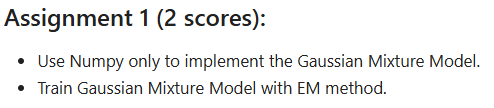

In [ ]:
class GaussianMixture:
    def __init__(self, n_components, max_iter=100, tol=1e-3):
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.means = None
        self.covariances = None
        self.responsibilities = None
        self.log_likelihood = []

    def _multivariate_normal_pdf(self, X, mean, covariance):
        D = X.shape[1]
        determinant = np.linalg.det(covariance)
        if determinant <= 0:
            covariance += np.eye(D) * 1e-6
            determinant = np.linalg.det(covariance)
            if determinant <= 0:
                raise ValueError("Covariance matrix is singular.")
        inv_covariance = np.linalg.inv(covariance)
        diff = X - mean
        exponent = -0.5 * np.sum(diff @ inv_covariance * diff, axis=1)
        pdf = (1.0 / np.sqrt((2 * np.pi) ** D * determinant)) * np.exp(exponent)
        return pdf

    def fit(self, X):
        N, D = X.shape
        K = self.K
        np.random.seed(42)
        random_indices = np.random.choice(N, K, replace=False)
        self.means = X[random_indices]
        self.covariances = np.array([np.eye(D)] * K)
        self.weights = np.ones(K) / K
        prev_log_likelihood = -np.inf

        for iteration in range(self.max_iter):
            responsibilities = np.zeros((N, K))
            for k in range(K):
                responsibilities[:, k] = self.weights[k] * self._multivariate_normal_pdf(X, self.means[k], self.covariances[k])

            sum_responsibilities = np.sum(responsibilities, axis=1, keepdims=True)
            sum_responsibilities[sum_responsibilities == 0] = 1e-10
            responsibilities /= sum_responsibilities
            N_k = np.sum(responsibilities, axis=0)
            N_k[N_k == 0] = 1e-10

            for k in range(K):
                self.means[k] = np.sum(responsibilities[:, k, np.newaxis] * X, axis=0) / N_k[k]
                diff = X - self.means[k]
                self.covariances[k] = (responsibilities[:, k, np.newaxis] * diff).T @ diff / N_k[k]
                self.covariances[k] += np.eye(D) * 1e-6
                self.weights[k] = N_k[k] / N

            log_likelihood = np.sum(np.log(np.sum(responsibilities * sum_responsibilities, axis=1)))
            self.log_likelihood.append(log_likelihood)

            if iteration > 0 and abs(log_likelihood - prev_log_likelihood) < self.tol:
                print(f"Converged at iteration {iteration}")
                break
            prev_log_likelihood = log_likelihood

    def predict_proba(self, X):
        N, _ = X.shape
        K = self.K
        weighted_pdfs = np.zeros((N, K))
        for k in range(K):
            weighted_pdfs[:, k] = self.weights[k] * self._multivariate_normal_pdf(X, self.means[k], self.covariances[k])
        sum_weighted_pdfs = np.sum(weighted_pdfs, axis=1, keepdims=True)
        sum_weighted_pdfs[sum_weighted_pdfs == 0] = 1e-10
        posterior_probabilities = weighted_pdfs / sum_weighted_pdfs
        return posterior_probabilities

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


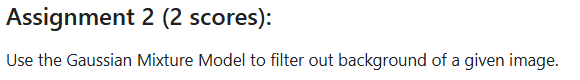

In [ ]:
image = imread('/content/cow.jpg')
image = resize(image, (68, 80), anti_aliasing=True)
pixels = image.reshape(-1, 3)

In [ ]:
gmm = GaussianMixture(n_components=3)
gmm.fit(pixels)
labels = gmm.predict(pixels)

Converged at iteration 36


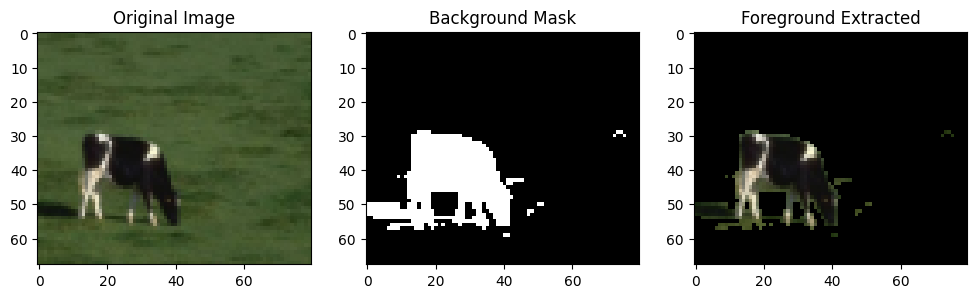

In [ ]:
bg_label = np.bincount(labels).argmax()

mask = (labels != bg_label).astype(np.uint8).reshape(image.shape[:2])
mask_rgb = np.stack([mask]*3, axis=-1)
foreground = image * mask_rgb

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.title("Background Mask")
plt.imshow(mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Foreground Extracted")
plt.imshow(foreground)
plt.show()